<a href="https://colab.research.google.com/github/philnumpy/PRML-PROJECT/blob/main/dbscanprml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DB SCAN

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial import KDTree

# Load dataset
file_path = "spotify_tracks.csv"
df = pd.read_csv(file_path)

# Select features
features = [
    "popularity", "acousticness", "danceability", "energy", "instrumentalness",
    "liveness", "loudness", "speechiness", "tempo", "valence"
]

# Normalize features
X = df[features].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Custom DBSCAN from scratch
class DBSCAN:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.labels = np.full(len(X), -1)  # Initialize all points as unclassified (-1)

    def fit(self, X):
        tree = KDTree(X)  # KDTree for fast neighbor search
        cluster_id = 0

        for i in range(len(X)):
            if self.labels[i] != -1:  # Already classified
                continue

            # Find neighbors
            neighbors = tree.query_ball_point(X[i], r=self.eps)

            if len(neighbors) < self.min_samples:
                self.labels[i] = -2  # Mark as noise
                continue

            # Expand cluster
            self._expand_cluster(tree, i, neighbors, cluster_id)
            cluster_id += 1

    def _expand_cluster(self, tree, i, neighbors, cluster_id):
        """Expands the cluster using density connectivity."""
        queue = set(neighbors)  # Use set to prevent duplicates
        self.labels[i] = cluster_id  # Assign cluster

        while queue:
            point = queue.pop()
            if self.labels[point] == -2:  # Convert noise to border point
                self.labels[point] = cluster_id
            if self.labels[point] != -1:  # Already assigned
                continue

            self.labels[point] = cluster_id
            new_neighbors = tree.query_ball_point(X[point], r=self.eps)

            if len(new_neighbors) >= self.min_samples:
                queue.update(set(new_neighbors) - queue)  # Add only new points

# Run DBSCAN
eps = 3.61# Adjust epsilon for better clusters
min_samples = 5  # Minimum songs in a cluster
dbscan = DBSCAN(eps, min_samples)
dbscan.fit(X)

df["cluster"] = dbscan.labels  # Assign clusters to dataset

# Recommendation function
def recommend_songs(input_song):
    song_row = df[df["track_name"].str.lower() == input_song.lower()]
    if song_row.empty:
        print("Song not found.")
        return

    song_cluster = song_row["cluster"].values[0]
    if song_cluster == -2:
        print("Song is marked as noise, no recommendations.")
        return

    recommendations = df[df["cluster"] == song_cluster].sample(n=5, random_state=42)

    print("\nRecommended Songs:")
    print(recommendations[["track_name", "artist_name"]])

# User input
input_song = input("Enter a song name: ")
recommend_songs(input_song)


Enter a song name: Leo Das Entry (From "Leo")

Recommended Songs:
                                track_name  \
4211   Danga Maari Oodhari (From "Anegan")   
35341                             My Bitch   
54072                        Tups Vertebra   
32083                 Big Boy (T.O.P Solo)   
52531                                Globo   

                                             artist_name  
4211   Harris Jayaraj, Dhanush, Marana Gana Viji, Nav...  
35341                                           THE BOYZ  
54072                                      Madonna Homma  
32083                                            BIGBANG  
52531                     Luigi Madonna, Alberto Pascual  


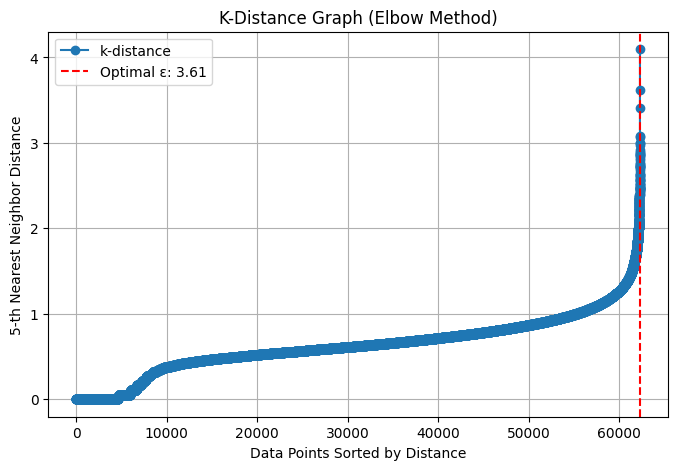

Optimal Epsilon (ε): 3.61


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Load the dataset
file_path = "spotify_tracks.csv"
df = pd.read_csv(file_path)

# Selecting relevant numerical features
features = [
    "popularity", "acousticness", "danceability", "energy", "instrumentalness",
    "liveness", "loudness", "speechiness", "tempo", "valence"
]

# Extract feature matrix and normalize
X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def find_optimal_epsilon(X, min_samples=5):
    """Finds the optimal epsilon for DBSCAN using the k-distance graph."""
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(X)

    distances, _ = neigh.kneighbors(X)
    k_distances = np.sort(distances[:, -1])  # Get k-th nearest distances

    # Find the elbow point automatically
    diff = np.diff(k_distances)
    elbow_index = np.argmax(diff)  # Point where distance increases the most
    optimal_eps = k_distances[elbow_index]

    # Plot the sorted k-distances
    plt.figure(figsize=(8, 5))
    plt.plot(k_distances, marker="o", label="k-distance")
    plt.axvline(elbow_index, color='r', linestyle='--', label=f'Optimal ε: {optimal_eps:.2f}')
    plt.xlabel("Data Points Sorted by Distance")
    plt.ylabel(f"{min_samples}-th Nearest Neighbor Distance")
    plt.title("K-Distance Graph (Elbow Method)")
    plt.legend()
    plt.grid()
    plt.show()

    return optimal_eps

# Compute optimal epsilon
optimal_eps = find_optimal_epsilon(X_scaled)
print(f"Optimal Epsilon (ε): {optimal_eps:.2f}")


WORKING OF THE CODE

The code implements DBSCAN (Density-Based Spatial Clustering of Applications with Noise) from scratch using a KDTree for efficient nearest-neighbor searches.

Step 1: Load and Preprocess the Data

    file_path = "spotify_tracks.csv"
    df = pd.read_csv(file_path)

Reads the dataset containing Spotify track features such as danceability, energy, loudness, etc.

Selecting relevant numerical features:

    features = [
    "popularity", "acousticness", "danceability", "energy", "instrumentalness",
    "liveness", "loudness", "speechiness", "tempo", "valence"
    ]

Extracts numerical features that define the characteristics of each song.

Feature normalization using StandardScaler:

    X = df[features].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

  Standardizes the feature values to have zero mean and unit variance, which helps DBSCAN work effectively regardless of different feature scales.



Step 2: Implementing DBSCAN from Scratch

Initializing the DBSCAN class:

    class DBSCAN:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.labels = np.full(len(X), -1)  # Initialize all points as unclassified (-1)
eps (epsilon): The maximum distance for a point to be considered a neighbor.

min_samples: The minimum number of points required to form a dense region (i.e., a cluster).

labels array: Assigns each point an initial label of -1 (unclassified).


Step 3: Fitting DBSCAN

Building a KDTree for Fast Nearest-Neighbor Search

    def fit(self, X):
    tree = KDTree(X)  # KDTree for fast neighbor search
    cluster_id = 0
Uses KDTree to quickly find points within a given radius (eps).

Iterating Through All Data Points:

    for i in range(len(X)):
    if self.labels[i] != -1:  # Already classified
        continue

    # Find neighbors
    neighbors = tree.query_ball_point(X[i], r=self.eps)

    if len(neighbors) < self.min_samples:
        self.labels[i] = -2  # Mark as noise
        continue

    # Expand cluster
    self._expand_cluster(tree, i, neighbors, cluster_id)
    cluster_id += 1

For each point i:

Finds nearby points within distance eps.

If fewer than min_samples neighbors exist, the point is marked as noise (-2).

Otherwise, it creates/expands a new cluster.




Step 4: Expanding Clusters

Expanding using Density Reachability

    def _expand_cluster(self, tree, i, neighbors, cluster_id):
    """Expands the cluster using density connectivity."""
    queue = set(neighbors)  # Use set to prevent duplicates
    self.labels[i] = cluster_id  # Assign cluster

    while queue:
        point = queue.pop()
        if self.labels[point] == -2:  # Convert noise to border point
            self.labels[point] = cluster_id
        if self.labels[point] != -1:  # Already assigned
            continue

        self.labels[point] = cluster_id
        new_neighbors = tree.query_ball_point(X[point], r=self.eps)

        if len(new_neighbors) >= self.min_samples:
            queue.update(set(new_neighbors) - queue)  # Add only new points


Expands clusters recursively:

Checks each point's density reachability.

Assigns points to the current cluster.

If new points have enough neighbors, adds them to the queue to continue expanding.


Step 5: Running DBSCAN

    eps = 3.61  # Optimal epsilon (determined from elbow method)
    min_samples = 5  # Minimum points for a cluster
    dbscan = DBSCAN(eps, min_samples)
    dbscan.fit(X)

    df["cluster"] = dbscan.labels  # Assign clusters to dataset

Uses eps = 3.61, which was obtained from the elbow method.

Runs DBSCAN and stores cluster labels in the dataset.

Step 6: Implementing the Recommendation System

Finding Similar Songs:

    def recommend_songs(input_song):
    song_row = df[df["track_name"].str.lower() == input_song.lower()]
    if song_row.empty:
        print("Song not found.")
        return

    song_cluster = song_row["cluster"].values[0]
    if song_cluster == -2:
        print("Song is marked as noise, no recommendations.")
        return

    recommendations = df[df["cluster"] == song_cluster].sample(n=5, random_state=42)
    
    print("\nRecommended Songs:")
    print(recommendations[["track_name", "artist_name"]])

Searches for the input song in the dataset.

Finds its cluster and recommends 5 other songs from the same cluster.

If the song is classified as noise, no recommendations are given.


Step 7: User Input and Recommendation

    input_song = input("Enter a song name: ")
    recommend_songs(input_song)
    
Takes user input and recommends songs from the same cluster.










Why Does the Output Change with Different eps?

Effect of eps on Clustering

A small eps value forms many small clusters, increasing noise points.

A large eps value forms fewer, larger clusters, making recommendations less specific.

The elbow method helped determine an optimal balance (eps = 3.61).

